In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D, proj3d
from matplotlib.patches import FancyArrowPatch
import cv2
import imageio.v2 as imageio
import numpy as np
import pandas as pd
from IPython.display import display, Math, Video
from enum import *
from sklearn import svm
import os
from os import listdir
from os.path import isfile, isdir, join
import time

startInstantTime = time.time()

In [2]:
#Parametros de ejecucion del programa
nombreArchivoInformacion = "InformacionEjercicioClasificacion.txt"
nombreArchivoDataset = "DatasetClasificacion.csv"
nombreArchivoAnimacion = "Animación del Perceptrón Simple"
tasaAprendizaje = 0.001
tiempoPausaAnimacion = 0.001

searchFolderPath = "./Figuras/"
imageFileExtension = ".jpg"
animationFileExtension = ".mp4"
framesPorSegundoAnimacion = 20

colorTextoVerde = (35, 155, 86)
colorTextoRojo = (176, 58, 46)

In [3]:
imageFileExtensionsList = [imageFileExtension]

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer = None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

In [4]:
#Se controla por medio de estados la clasificacion de todas las muestras de una clase dada
class EstadosClasificacion(Enum):
    estado1 = "Todas las muestras de la clase 1 están efectivamente en la clase 1"
    estado2 = "Todas las muestras de la clase 2 están efectivamente en la clase 2"
    estado3 = "Se tiene al menos una muestra en la clase equivocada"

def printColouredText(text, foregroundColor = (0, 0, 0), backgroundColor = (255, 255, 255)):
    return "\033[48;2;{};{};{}m\033[38;2;{};{};{}m{}\033[38;2;0;0;0m\033[48;2;255;255;255m".format(backgroundColor[0], backgroundColor[1], backgroundColor[2], foregroundColor[0], foregroundColor[1], foregroundColor[2], text)

def getFilesListOfSomeExtensionAtSomeDirectory(searchFolderPath, fileExtensionsList):
    informativeMessage = ""
    filesList = [file for file in listdir(searchFolderPath) if isfile(join(searchFolderPath, file))]
    filesList = [file for file in filesList if file[len(file) - 4:] in fileExtensionsList]
    filesList.sort(key = lambda file: os.path.getmtime(join(searchFolderPath, file)))
    numberFilesFound = len(filesList)
    if numberFilesFound == 0:
        informativeMessage = "No hay archivos con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    elif numberFilesFound == 1:
        informativeMessage = "Solo hay un archivo con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    else:
        informativeMessage = "Hay " + str(numberFilesFound) + " archivos con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    return filesList, informativeMessage

def deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, fileExtensionsList):
    informativeMessage = ""
    filesList = [file for file in listdir(searchFolderPath) if isfile(join(searchFolderPath, file))]
    filesList = [file for file in filesList if file[len(file) - 4:] in fileExtensionsList]
    numberFilesFound = len(filesList)
    if numberFilesFound == 0:
        informativeMessage = "No hay archivos con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    elif numberFilesFound == 1:
        informativeMessage = "Solo hay un archivo con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    else:
        informativeMessage = "Hay " + str(numberFilesFound) + " archivos con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    
    for file in filesList:
        os.remove(join(searchFolderPath, file))
    return informativeMessage

def resizeImage(image, width = None, height = None, interpolationTechnique = cv2.INTER_AREA):
    newImageSize = None
    ratioFactor = 1.0
    (imageHeight, imageWidth) = image.shape[:2]
    
    #The ratio factor is computed (only in case to get exactly one of the parameters (width or height) in None), otherwise, the image will be resized without keep its aspect ratio
    if width is None and height is None:
        return image
    if width is None:
        ratioFactor = height / float(imageHeight)
        newImageSize = (int(imageWidth * ratioFactor), height)
    elif height is None:
        ratioFactor = width / float(imageWidth)
        newImageSize = (width, int(imageHeight * ratioFactor))
    else:
        newImageSize = (width, height)
    resizedImage = cv2.resize(image, newImageSize, interpolation = interpolationTechnique)
    return resizedImage

#El ajuste de tamaño comun a las imagenes esta hecho con reescalado al tamaño maximo/minimo o con un slice/recorte al tamaño minimo
def overwriteFittedImagesToCommonSize(searchFolderPath, imageFilesList):
    numberImageFilesFound = len(imageFilesList)
    if numberImageFilesFound >= 1:
        maximumWidthForAllImages = -1
        maximumHeightForAllImages = -1
        #minimumWidthForAllImages = float('inf')
        #minimumHeightForAllImages = float('inf')
        for imageFile in imageFilesList:
            originalImage = cv2.imread(join(searchFolderPath, imageFile), -1)
            originalImageWidth = originalImage.shape[1]
            originalImageHeight = originalImage.shape[0]
            if originalImageWidth > maximumWidthForAllImages:
                maximumWidthForAllImages = originalImageWidth
            if originalImageHeight > maximumHeightForAllImages:
                maximumHeightForAllImages = originalImageHeight
            #if originalImageWidth < minimumWidthForAllImages:
                #minimumWidthForAllImages = originalImageWidth
            #if originalImageHeight < minimumHeightForAllImages:
                #minimumHeightForAllImages = originalImageHeight
                
        for imageFile in imageFilesList:
            originalImage = cv2.imread(join(searchFolderPath, imageFile), -1)
            originalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
            originalImage = resizeImage(originalImage, width = maximumWidthForAllImages, height = maximumHeightForAllImages)
            #originalImage = originalImage[0:minimumHeightForAllImages, 0:minimumWidthForAllImages]
            cv2.imwrite(join(searchFolderPath, imageFile), originalImage)
        print("Se han ajustado " + printColouredText(str(numberImageFilesFound) + " imágen(es)", colorTextoVerde) + " a un tamaño común que es de " + printColouredText(str(maximumWidthForAllImages) + "x" + str(maximumHeightForAllImages), colorTextoVerde) + " como máximo de ancho por máximo de alto")
        #print("Se han ajustado " + printColouredText(str(numberImageFilesFound) + " imágen(es)", colorTextoVerde) + " a un tamaño común que es de " + printColouredText(str(minimumWidthForAllImages) + "x" + str(minimumHeightForAllImages), colorTextoVerde) + " como mínimo de ancho por mínimo de alto")
    else:
        print(printColouredText("La lista dada está vacía", colorTextoRojo))

def createAnimationFromImageFilesAtSomeDirectory(searchFolderPath, imageFileExtensionsList, animationFilename, animationFileExtension, frameRate):
    imageFilesList, informativeMessage = getFilesListOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
    overwriteFittedImagesToCommonSize(searchFolderPath, imageFilesList)
    animationFilePath = join(searchFolderPath, animationFilename + animationFileExtension)
    
    writerStream = imageio.get_writer(animationFilePath, fps = frameRate)
    for imageFile in imageFilesList:
        writerStream.append_data(imageio.imread(join(searchFolderPath, imageFile)))
    writerStream.close()
    print("Se ha creado el archivo", printColouredText(animationFilePath, colorTextoVerde))
    return animationFilePath

def evaluarPuntoRespectoAHiperplano(listaCoeficientesHiperplano, punto):
    numeroDimensionesEspacio = len(listaCoeficientesHiperplano) - 1
    return np.dot(listaCoeficientesHiperplano[0:numeroDimensionesEspacio], punto) + listaCoeficientesHiperplano[numeroDimensionesEspacio]

def obtenerListasCoordenadasRespectivas(listaPuntos, numeroDimensiones):
    diccionarioPuntosPorCoordenadas = {}
    for indice in range(numeroDimensiones):
        diccionarioPuntosPorCoordenadas[indice] = []
    
    for puntoActual in listaPuntos:
        for indice in range(numeroDimensiones):
            coordenadaActual = puntoActual[indice]
            diccionarioPuntosPorCoordenadas[indice].append(coordenadaActual)
    return diccionarioPuntosPorCoordenadas

def crearTextoEcuacionHiperplano(listaCoeficientesHiperplano):
    numeroDimensionesEspacio = len(listaCoeficientesHiperplano) - 1
    diccionarioCoeficientesNoNulos = {}
    for indice in range(numeroDimensionesEspacio + 1):
        if listaCoeficientesHiperplano[indice] != 0.0:
            diccionarioCoeficientesNoNulos[indice] = listaCoeficientesHiperplano[indice]
    
    textoEcuacionHiperplano = ''
    nuevoIndiceCoeficienteNoNulo = 0
    if numeroDimensionesEspacio <= 3:
        for indice in diccionarioCoeficientesNoNulos.keys():
            if nuevoIndiceCoeficienteNoNulo == 0:
                if diccionarioCoeficientesNoNulos[indice] == 1.0:
                    textoEcuacionHiperplano = r'' + chr(indice + 120)
                elif diccionarioCoeficientesNoNulos[indice] == -1.0:
                    textoEcuacionHiperplano = r'-' + chr(indice + 120)
                else:
                    textoEcuacionHiperplano = r'{}'.format(diccionarioCoeficientesNoNulos[indice]) + chr(indice + 120)
            elif nuevoIndiceCoeficienteNoNulo == len(diccionarioCoeficientesNoNulos.keys()) - 1:
                if indice == numeroDimensionesEspacio:
                    if diccionarioCoeficientesNoNulos[indice] > 0.0:
                        textoEcuacionHiperplano += ' + {}'.format(diccionarioCoeficientesNoNulos[indice])
                    elif diccionarioCoeficientesNoNulos[indice] < 0.0:
                        textoEcuacionHiperplano += ' - {}'.format(np.abs(diccionarioCoeficientesNoNulos[indice]))
                else:
                    if diccionarioCoeficientesNoNulos[indice] > 0.0:
                        if diccionarioCoeficientesNoNulos[indice] == 1.0:
                            textoEcuacionHiperplano += ' + ' + chr(indice + 120)
                        else:
                            textoEcuacionHiperplano += ' + {}'.format(diccionarioCoeficientesNoNulos[indice]) + chr(indice + 120)
                    elif diccionarioCoeficientesNoNulos[indice] < 0.0:
                        if diccionarioCoeficientesNoNulos[indice] == -1.0:
                            textoEcuacionHiperplano += ' - ' + chr(indice + 120)
                        else:
                            textoEcuacionHiperplano += ' - {}'.format(np.abs(diccionarioCoeficientesNoNulos[indice])) + chr(indice + 120)
            else:
                if diccionarioCoeficientesNoNulos[indice] > 0.0:
                    if diccionarioCoeficientesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' + ' + chr(indice + 120)
                    else:
                        textoEcuacionHiperplano += ' + {}'.format(diccionarioCoeficientesNoNulos[indice]) + chr(indice + 120)
                elif diccionarioCoeficientesNoNulos[indice] < 0.0:
                    if diccionarioCoeficientesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' - ' + chr(indice + 120)
                    else:
                        textoEcuacionHiperplano += ' - {}'.format(np.abs(diccionarioCoeficientesNoNulos[indice])) + chr(indice + 120)
            nuevoIndiceCoeficienteNoNulo += 1
    else:
        for indice in diccionarioCoeficientesNoNulos.keys():
            if nuevoIndiceCoeficienteNoNulo == 0:
                if diccionarioCoeficientesNoNulos[indice] == 1.0:
                    textoEcuacionHiperplano = r'x_{' + str(indice + 1) + '}'
                elif diccionarioCoeficientesNoNulos[indice] == -1.0:
                    textoEcuacionHiperplano = r'-x_{' + str(indice + 1) + '}'
                else:
                    textoEcuacionHiperplano = r'{}x'.format(listaCoeficientesHiperplano[indice]) + '_{' + str(indice + 1) + '}'
            elif nuevoIndiceCoeficienteNoNulo == len(diccionarioCoeficientesNoNulos.keys()) - 1:
                if indice == numeroDimensionesEspacio:
                    if diccionarioCoeficientesNoNulos[indice] > 0.0:
                        textoEcuacionHiperplano += ' + {}'.format(diccionarioCoeficientesNoNulos[indice])
                    elif diccionarioCoeficientesNoNulos[indice] < 0.0:
                        textoEcuacionHiperplano += ' - {}'.format(np.abs(diccionarioCoeficientesNoNulos[indice]))
                else:
                    if diccionarioCoeficientesNoNulos[indice] > 0.0:
                        if diccionarioCoeficientesNoNulos[indice] == 1.0:
                            textoEcuacionHiperplano += ' + x_{' + str(indice + 1) + '}'
                        else:
                            textoEcuacionHiperplano += ' + {}x'.format(diccionarioCoeficientesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                    elif diccionarioCoeficientesNoNulos[indice] < 0.0:
                        if diccionarioCoeficientesNoNulos[indice] == -1.0:
                            textoEcuacionHiperplano += ' - x_{' + str(indice + 1) + '}'
                        else:
                            textoEcuacionHiperplano += ' - {}x'.format(np.abs(diccionarioCoeficientesNoNulos[indice])) + '_{' + str(indice + 1)  + '}'
            else:
                if diccionarioCoeficientesNoNulos[indice] > 0.0:
                    if diccionarioCoeficientesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' + x_{' + str(indice + 1) + '}'
                    else:
                        textoEcuacionHiperplano += ' + {}x'.format(diccionarioCoeficientesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                elif diccionarioCoeficientesNoNulos[indice] < 0.0:
                    if diccionarioCoeficientesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' - x_{' + str(indice + 1) + '}'
                    else:
                        textoEcuacionHiperplano += ' - {}x'.format(np.abs(diccionarioCoeficientesNoNulos[indice])) + '_{' + str(indice + 1) + '}'
            nuevoIndiceCoeficienteNoNulo += 1
    textoEcuacionHiperplano += ' = 0'
    return textoEcuacionHiperplano

def crearTextoVector(vector):
    numeroDimensionesEspacio = len(vector)
    textoVector = r'\left( '
    for indice in range(numeroDimensionesEspacio):
        if indice == numeroDimensionesEspacio - 1:
            textoVector += str(vector[indice])
        else:
            textoVector += str(vector[indice]) + ', '
    textoVector += r' \right)'
    return textoVector

In [5]:
def actualizarHiperplanoClasificacion(listaCoeficientesHiperplanoInicial, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje):
    numeroDimensionesEspacio = len(listaCoeficientesHiperplanoInicial) - 1
    listaCoeficientesHiperplanoActualizado = listaCoeficientesHiperplanoInicial
    puntoMuestraSeleccionado = listaPuntosMuestra[np.random.randint(len(listaPuntosMuestra))]
    valorPuntoMuestraSeleccionado = evaluarPuntoRespectoAHiperplano(listaCoeficientesHiperplanoActualizado, puntoMuestraSeleccionado)
    if not ((valorPuntoMuestraSeleccionado >= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]) or (valorPuntoMuestraSeleccionado <= 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2])):
        if valorPuntoMuestraSeleccionado < 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase1]:
            for indice in range(numeroDimensionesEspacio):
                listaCoeficientesHiperplanoActualizado[indice] += tasaAprendizaje * puntoMuestraSeleccionado[indice]
            listaCoeficientesHiperplanoActualizado[numeroDimensionesEspacio] += tasaAprendizaje
        elif valorPuntoMuestraSeleccionado > 0.0 and puntoMuestraSeleccionado in muestraPuntosPorClases[nombreClase2]:
            for indice in range(numeroDimensionesEspacio):
                listaCoeficientesHiperplanoActualizado[indice] -= tasaAprendizaje * puntoMuestraSeleccionado[indice]
            listaCoeficientesHiperplanoActualizado[numeroDimensionesEspacio] -= tasaAprendizaje
    return listaCoeficientesHiperplanoActualizado

def verificarMuestrasClasificadasEnUnaSolaClase(listaCoeficientesHiperplano, muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClaseObjetivo):
    clasePuntoActual = nombreClaseObjetivo
    clasePuntoAnterior = nombreClaseObjetivo
    for punto in muestraPuntosPorClases[nombreClaseObjetivo]:
        clasePuntoAnterior = clasePuntoActual
        valorPunto = evaluarPuntoRespectoAHiperplano(listaCoeficientesHiperplano, punto)
        if valorPunto > 0.0:
            clasePuntoActual = nombreClase1
        elif valorPunto < 0.0:
            clasePuntoActual = nombreClase2
        else:
            return EstadosClasificacion.estado3
        if clasePuntoActual != clasePuntoAnterior:
            return EstadosClasificacion.estado3
    
    if clasePuntoActual == nombreClase1:
        return EstadosClasificacion.estado1
    elif clasePuntoActual == nombreClase2:
        return EstadosClasificacion.estado2
    return EstadosClasificacion.estado3

def verificarClasificacionCorrecta(listaCoeficientesHiperplano, muestraPuntosPorClases, nombreClase1, nombreClase2):
    revisionClasificacion1 = verificarMuestrasClasificadasEnUnaSolaClase(listaCoeficientesHiperplano, muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase1)
    revisionClasificacion2 = verificarMuestrasClasificadasEnUnaSolaClase(listaCoeficientesHiperplano, muestraPuntosPorClases, nombreClase1, nombreClase2, nombreClase2)
    return revisionClasificacion1.value == EstadosClasificacion.estado1.value and revisionClasificacion2.value == EstadosClasificacion.estado2.value

def calcularValoresMatrizConfusion2Categorias(listaCoeficientesHiperplano, muestraPuntosPorClases, nombreClase1, nombreClase2):
    cantidadVerdaderosPositivos = 0
    cantidadVerdaderosNegativos = 0
    cantidadFalsosPositivos = 0
    cantidadFalsosNegativos = 0
    
    for punto in muestraPuntosPorClases[nombreClase1]:
        valorPunto = evaluarPuntoRespectoAHiperplano(listaCoeficientesHiperplano, punto)
        if valorPunto > 0.0:
            cantidadVerdaderosPositivos += 1
        else:
            cantidadFalsosNegativos += 1
    
    for punto in muestraPuntosPorClases[nombreClase2]:
        valorPunto = evaluarPuntoRespectoAHiperplano(listaCoeficientesHiperplano, punto)
        if valorPunto < 0.0:
            cantidadVerdaderosNegativos += 1
        else:
            cantidadFalsosPositivos += 1
    return cantidadVerdaderosPositivos, cantidadVerdaderosNegativos, cantidadFalsosPositivos, cantidadFalsosNegativos

def algoritmoPerceptronSimple(listaCoeficientesHiperplanoInicial, listaCoeficientesHiperplanoSeparacionMaxima, listaVectoresSoporte, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje, numeroDimensiones):
    listaCoeficientesHiperplanoActualizado = listaCoeficientesHiperplanoInicial
    clasificacionCompletada = verificarClasificacionCorrecta(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2)
    cantidadVerdaderosPositivos, cantidadVerdaderosNegativos, cantidadFalsosPositivos, cantidadFalsosNegativos = calcularValoresMatrizConfusion2Categorias(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2)
    listaCantidadesVerdaderosPositivos = [cantidadVerdaderosPositivos]
    listaCantidadesVerdaderosNegativos = [cantidadVerdaderosNegativos]
    listaCantidadesFalsosPositivos = [cantidadFalsosPositivos]
    listaCantidadesFalsosNegativos = [cantidadFalsosNegativos]
    
    numeroPasos = 0
    if clasificacionCompletada == False:
        mensajeConfirmacion = deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
        print(printColouredText(mensajeConfirmacion, colorTextoRojo))
        if numeroDimensiones == 1:
            plt.ion()
            while clasificacionCompletada == False:
                plt.clf()
                listaCoeficientesHiperplanoActualizado = actualizarHiperplanoClasificacion(listaCoeficientesHiperplanoActualizado, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje)
                cantidadVerdaderosPositivos, cantidadVerdaderosNegativos, cantidadFalsosPositivos, cantidadFalsosNegativos = calcularValoresMatrizConfusion2Categorias(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2)
                listaCantidadesVerdaderosPositivos.append(cantidadVerdaderosPositivos)
                listaCantidadesVerdaderosNegativos.append(cantidadVerdaderosNegativos)
                listaCantidadesFalsosPositivos.append(cantidadFalsosPositivos)
                listaCantidadesFalsosNegativos.append(cantidadFalsosNegativos)

                listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
                listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
                valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
                valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
                valoresCoordenadasYPuntosClase1 = [0.0] * len(listaPuntosClase1PorCoordenadasRespectivas[0])
                valoresCoordenadasYPuntosClase2 = [0.0] * len(listaPuntosClase2PorCoordenadasRespectivas[0])
                minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
                maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1

                plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
                plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
                plt.axvline(x = -listaCoeficientesHiperplanoActualizado[numeroDimensiones] / listaCoeficientesHiperplanoActualizado[numeroDimensiones - 1], color = 'm', linestyle = '-', label = "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)", linewidth = 2.5)
                plt.axvline(x = -listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones] / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1], color = 'g', linestyle = '-', label = "Frontera de Decisión de Máxima Separación (SVM)", linewidth = 2.5)
                for vector in listaVectoresSoporte:
                    plt.arrow(0, 0, vector[numeroDimensiones - 1], 0.0, head_width = 0.4, head_length = 0.4, fc = 'k', ec = 'k')
                plt.legend(loc = 'upper left')
                plt.xlabel("Eje X")
                plt.ylabel("")
                plt.gca().get_yaxis().set_visible(False)
                plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
                plt.grid(True)

                numeroPasos += 1
                clasificacionCompletada = verificarClasificacionCorrecta(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2)

                plt.pause(tiempoPausaAnimacion)
                plt.show()
            plt.ioff()
            plt.show()
        elif numeroDimensiones == 2:
            plt.ion()
            while clasificacionCompletada == False:
                plt.clf()
                listaCoeficientesHiperplanoActualizado = actualizarHiperplanoClasificacion(listaCoeficientesHiperplanoActualizado, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje)
                cantidadVerdaderosPositivos, cantidadVerdaderosNegativos, cantidadFalsosPositivos, cantidadFalsosNegativos = calcularValoresMatrizConfusion2Categorias(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2)
                listaCantidadesVerdaderosPositivos.append(cantidadVerdaderosPositivos)
                listaCantidadesVerdaderosNegativos.append(cantidadVerdaderosNegativos)
                listaCantidadesFalsosPositivos.append(cantidadFalsosPositivos)
                listaCantidadesFalsosNegativos.append(cantidadFalsosNegativos)

                listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
                listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
                valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
                valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
                valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
                valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
                minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
                maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
                minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
                maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1

                listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
                listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
                if listaCoeficientesHiperplanoActualizado[numeroDimensiones - 1] != 0.0:
                    listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesHiperplanoActualizado[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoActualizado[numeroDimensiones]) / listaCoeficientesHiperplanoActualizado[numeroDimensiones - 1]
                elif listaCoeficientesHiperplanoActualizado[numeroDimensiones - 2] != 0.0:
                    listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesHiperplanoActualizado[numeroDimensiones] / listaCoeficientesHiperplanoActualizado[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion

                listaValoresCoordenadaXHiperplanoSeparacionMaxima = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
                listaValoresCoordenadaYHiperplanoSeparacionMaxima = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
                if listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1] != 0.0:
                    listaValoresCoordenadaYHiperplanoSeparacionMaxima = -(listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones]) / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1]
                elif listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] != 0.0:
                    listaValoresCoordenadaXHiperplanoSeparacionMaxima = [-listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones] / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion

                plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
                plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
                plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'm-', label = "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)")
                plt.plot(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima, 'g-', label = "Frontera de Decisión de Máxima Separación (SVM)")
                for vector in listaVectoresSoporte:
                    plt.arrow(0, 0, vector[numeroDimensiones - 2], vector[numeroDimensiones - 1], head_width = 0.4, head_length = 0.4, fc = 'k', ec = 'k')
                plt.legend(loc = 'upper left')
                plt.xlabel("Eje X")
                plt.ylabel("Eje Y")
                plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
                plt.grid(True)

                numeroPasos += 1
                clasificacionCompletada = verificarClasificacionCorrecta(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2)

                plt.pause(tiempoPausaAnimacion)
                plt.show()
            plt.ioff()
            plt.show()
        elif numeroDimensiones == 3:
            currentFigure = plt.figure(num = 2, figsize = (9, 8))
            ax = currentFigure.gca(projection = '3d')
            ax.view_init(elev = -168, azim = 15) #Se ajusta la perspectiva manualmente de forma que se pueda visualizar los planos de separacion, los vectores de soporte y evidencia que separen los datos segun la clase a la que pertenecen (Si se cambia de plano para generar los puntos de muestra, se recomienda ajustar adecuadamente la perspectiva)
            plt.ion()
            while clasificacionCompletada == False:
                ax.cla()
                listaCoeficientesHiperplanoActualizado = actualizarHiperplanoClasificacion(listaCoeficientesHiperplanoActualizado, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje)
                cantidadVerdaderosPositivos, cantidadVerdaderosNegativos, cantidadFalsosPositivos, cantidadFalsosNegativos = calcularValoresMatrizConfusion2Categorias(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2)
                listaCantidadesVerdaderosPositivos.append(cantidadVerdaderosPositivos)
                listaCantidadesVerdaderosNegativos.append(cantidadVerdaderosNegativos)
                listaCantidadesFalsosPositivos.append(cantidadFalsosPositivos)
                listaCantidadesFalsosNegativos.append(cantidadFalsosNegativos)

                listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
                listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
                valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
                valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
                valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
                valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
                valoresCoordenadasZPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[2]
                valoresCoordenadasZPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[2]
                minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
                maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
                minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
                maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
                minimoEjeZ = np.min(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) - 1
                maximoEjeZ = np.max(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) + 1

                listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
                listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
                listaValoresCoordenadaZHiperplanoBase = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
                if listaCoeficientesHiperplanoActualizado[numeroDimensiones - 1] != 0.0:
                    listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
                    listaValoresCoordenadaZHiperplanoBase = -(listaCoeficientesHiperplanoActualizado[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoActualizado[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesHiperplanoActualizado[numeroDimensiones]) / listaCoeficientesHiperplanoActualizado[numeroDimensiones - 1]
                elif listaCoeficientesHiperplanoActualizado[numeroDimensiones - 2] != 0.0:
                    listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
                    listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesHiperplanoActualizado[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoActualizado[numeroDimensiones]) / listaCoeficientesHiperplanoActualizado[numeroDimensiones - 2]
                elif listaCoeficientesHiperplanoActualizado[numeroDimensiones - 3] != 0.0:
                    listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
                    listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesHiperplanoActualizado[numeroDimensiones] / listaCoeficientesHiperplanoActualizado[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion

                listaValoresCoordenadaXHiperplanoSeparacionMaxima = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
                listaValoresCoordenadaYHiperplanoSeparacionMaxima = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
                listaValoresCoordenadaZHiperplanoSeparacionMaxima = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
                if listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1] != 0.0:
                    listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima = np.meshgrid(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima)
                    listaValoresCoordenadaZHiperplanoSeparacionMaxima = -(listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones]) / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1]
                elif listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] != 0.0:
                    listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima = np.meshgrid(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima)
                    listaValoresCoordenadaYHiperplanoSeparacionMaxima = -(listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones]) / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2]
                elif listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3] != 0.0:
                    listaValoresCoordenadaYHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima = np.meshgrid(listaValoresCoordenadaYHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima)
                    listaValoresCoordenadaXHiperplanoSeparacionMaxima = [-listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion

                ax.scatter(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, valoresCoordenadasZPuntosClase1, c = 'b', marker = 'o')
                etiquetaLeyendaPuntosClase1 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'b', marker = 'o')
                ax.scatter(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, valoresCoordenadasZPuntosClase2, c = 'r', marker = 'o')
                etiquetaLeyendaPuntosClase2 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
                ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'm', alpha = 0.35)
                etiquetaLeyendaPlanoBase = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'm')
                ax.plot_surface(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima, color = 'g', alpha = 0.25)
                etiquetaLeyendaPlanoSeparacionMaxima = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
                for vector in listaVectoresSoporte:
                    flechaVector = Arrow3D([0.0, vector[numeroDimensiones - 3]], [0.0, vector[numeroDimensiones - 2]], [0.0, vector[numeroDimensiones - 1]], mutation_scale = 12, lw = 2.5, arrowstyle = "-|>", color = "k")
                    ax.add_artist(flechaVector)
                ax.set_xlabel("Eje X")
                ax.set_ylabel("Eje Y")
                ax.set_zlabel("Eje Z")
                ax.set_title("Visualización del Plano de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
                ax.legend([etiquetaLeyendaPuntosClase1, etiquetaLeyendaPuntosClase2, etiquetaLeyendaPlanoBase, etiquetaLeyendaPlanoSeparacionMaxima], ["Muestras de la Clase 1", "Muestras de la Clase 2", "Frontera de Decisión Propuesta (Algoritmo del Perceptrón Simple)", "Frontera de Decisión de Máxima Separación (SVM)"], numpoints = 1)
                plt.tight_layout()

                numeroPasos += 1
                clasificacionCompletada = verificarClasificacionCorrecta(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2)

                plt.pause(tiempoPausaAnimacion)
                rutaArchivoImagenActual = searchFolderPath + 'Frame ' + str(numeroPasos) + imageFileExtension
                plt.savefig(rutaArchivoImagenActual, bbox_inches = 'tight')
                plt.show()
            plt.ioff()
            plt.show()
        elif numeroDimensiones >= 4:
            while clasificacionCompletada == False:
                listaCoeficientesHiperplanoActualizado = actualizarHiperplanoClasificacion(listaCoeficientesHiperplanoActualizado, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje)
                cantidadVerdaderosPositivos, cantidadVerdaderosNegativos, cantidadFalsosPositivos, cantidadFalsosNegativos = calcularValoresMatrizConfusion2Categorias(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2)
                listaCantidadesVerdaderosPositivos.append(cantidadVerdaderosPositivos)
                listaCantidadesVerdaderosNegativos.append(cantidadVerdaderosNegativos)
                listaCantidadesFalsosPositivos.append(cantidadFalsosPositivos)
                listaCantidadesFalsosNegativos.append(cantidadFalsosNegativos)
                numeroPasos += 1
                clasificacionCompletada = verificarClasificacionCorrecta(listaCoeficientesHiperplanoActualizado, muestraPuntosPorClases, nombreClase1, nombreClase2)
    else:
        if numeroDimensiones == 1 or numeroDimensiones == 2:
            print("La recta dada separa perfectamente los puntos de las 2 clases")
        elif numeroDimensiones == 3:
            print("El plano dado separa perfectamente los puntos de las 2 clases")
        elif numeroDimensiones >= 4:
            print("El hiperplano dado separa perfectamente los puntos de las 2 clases")
    return listaCoeficientesHiperplanoActualizado, listaCantidadesVerdaderosPositivos, listaCantidadesVerdaderosNegativos, listaCantidadesFalsosPositivos, listaCantidadesFalsosNegativos, numeroPasos

In [6]:
numeroDimensiones = None
nombreClase1 = None
nombreClase2 = None
listaCoeficientesHiperplanoBase = []
etiquetaCoordenadaPuntos = None
nombreColumnaClaseAsignada = None

inputStream = open(nombreArchivoInformacion, "r")
lineasTextoArchivo = inputStream.readlines()
for numeroLineaActual in range(len(lineasTextoArchivo)):
    if numeroLineaActual == 0:
        numeroDimensiones = int(lineasTextoArchivo[numeroLineaActual].strip())
    elif numeroLineaActual == 1:
        nombreClase1 = lineasTextoArchivo[numeroLineaActual].strip()
    elif numeroLineaActual == 2:
        nombreClase2 = lineasTextoArchivo[numeroLineaActual].strip()
    elif numeroLineaActual == 3:
        lineaTextoActual = lineasTextoArchivo[numeroLineaActual].strip()
        lineaTextoActual = lineaTextoActual[1:(len(lineaTextoActual) - 1)]
        datosCoeficientesHiperplano = lineaTextoActual.split(", ")
        for coeficiente in datosCoeficientesHiperplano:
            listaCoeficientesHiperplanoBase.append(float(coeficiente))
    elif numeroLineaActual == 4:
        etiquetaCoordenadaPuntos = lineasTextoArchivo[numeroLineaActual].strip()
    elif numeroLineaActual == 5:
        nombreColumnaClaseAsignada = lineasTextoArchivo[numeroLineaActual].strip()
inputStream.close()

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoInformacion, colorTextoVerde))
print("Se está trabajando sobre", printColouredText(str(numeroDimensiones) + " dimension(es)", colorTextoVerde))
print("Los coeficientes del plano sobre el cual se generó el dataset de puntos para clasificación son:", printColouredText(str(listaCoeficientesHiperplanoBase), colorTextoRojo))

Se ha extraído la información del archivo InformacionEjercicioClasificacion.txt
Se está trabajando sobre 3 dimension(es)
Los coeficientes del plano sobre el cual se generó el dataset de puntos para clasificación son: [-0.01943366555916115, -0.1058730157519574, 0.052893477644297304, -0.38773232945438574]


In [7]:
datasetFile = pd.read_csv(nombreArchivoDataset)

listaPuntosMuestra = []
muestraPuntosPorClases = {nombreClase1: [], nombreClase2: []}
for indicefilaActual, filaActual in datasetFile.iterrows():
    puntoActual = []
    for indice in range(numeroDimensiones):
        nombreColumnaActual = "Coordenada $" + etiquetaCoordenadaPuntos + "_{" + str(indice + 1) + "}$"
        puntoActual.append(filaActual[nombreColumnaActual])
    categoriaPuntoActual = filaActual[nombreColumnaClaseAsignada]
    listaPuntosMuestra.append(puntoActual)
    muestraPuntosPorClases[categoriaPuntoActual].append(puntoActual)

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoDataset, colorTextoVerde))
print("Se tiene un total de", printColouredText(str(len(listaPuntosMuestra)) + " punto(s)", colorTextoVerde))
print("De la clase", printColouredText(nombreClase1, colorTextoRojo), "se tienen", printColouredText(str(len(muestraPuntosPorClases[nombreClase1])) + " punto(s)", colorTextoRojo))
print("De la clase", printColouredText(nombreClase2, colorTextoRojo), "se tienen", printColouredText(str(len(muestraPuntosPorClases[nombreClase2])) + " punto(s)", colorTextoRojo))

Se ha extraído la información del archivo DatasetClasificacion.csv
Se tiene un total de 2250 punto(s)
De la clase Clase 1 se tienen 1250 punto(s)
De la clase Clase 2 se tienen 1000 punto(s)


In [8]:
#Esta parte se puede comentar para que no se proponga inicialmente un hiperplano de coeficientes aleatorios sino para que el hiperplano propuesto inicialmente separe perfectamente las muestras de las 2 clases y por lo tanto no se realizaran iteraciones del algoritmo del perceptron simple
listaCoeficientesHiperplanoBase = list(np.random.uniform(low = -1.0, high = 1.0, size = numeroDimensiones + 1))
while listaCoeficientesHiperplanoBase[0:numeroDimensiones] == [0] * numeroDimensiones:
    listaCoeficientesHiperplanoBase = list(np.random.uniform(low = -1.0, high = 1.0, size = numeroDimensiones + 1))

textoEcuacionHiperplanoBase = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoBase)
if numeroDimensiones == 1 or numeroDimensiones == 2:
    print("La recta propuesta inicialmente para ejecutar el algoritmo del perceptrón simple, está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El plano propuesto inicialmente para ejecutar el algoritmo del perceptrón simple, está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El hiperplano propuesto inicialmente para ejecutar el algoritmo del perceptrón simple, está dado por la ecuación:")
display(Math(textoEcuacionHiperplanoBase))

El plano propuesto inicialmente para ejecutar el algoritmo del perceptrón simple, está dado por la ecuación:


<IPython.core.display.Math object>

In [9]:
listaCategoriasRespectivosPuntosMuestra = [nombreClase1] * len(muestraPuntosPorClases[nombreClase1]) + [nombreClase2] * len(muestraPuntosPorClases[nombreClase2])
listaCategoriasRespectivosPuntosMuestra = np.array(listaCategoriasRespectivosPuntosMuestra)
listaPuntosMuestraParaSVM = np.array(muestraPuntosPorClases[nombreClase1] + muestraPuntosPorClases[nombreClase2])
clf = svm.SVC(kernel = 'linear', C = 1.0)
clf.fit(listaPuntosMuestraParaSVM, listaCategoriasRespectivosPuntosMuestra)

listaCoeficientesHiperplanoSeparacionMaxima = []
for valor in clf.coef_[0]:
    listaCoeficientesHiperplanoSeparacionMaxima.append(valor)
listaCoeficientesHiperplanoSeparacionMaxima.append(clf.intercept_[0])

textoEcuacionHiperplanoSeparacionMaxima = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoSeparacionMaxima)
if numeroDimensiones == 1 or numeroDimensiones == 2:
    print("La recta de máxima separación obtenida por medio de una SVM (Support Vector Machine), está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El plano de máxima separación obtenido por medio de una SVM (Support Vector Machine), está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El hiperplano de máxima separación obtenido por medio de una SVM (Support Vector Machine), está dado por la ecuación:")
display(Math(textoEcuacionHiperplanoSeparacionMaxima))

listaVectoresSoporte = []
for vector in clf.support_vectors_:
    vectorSoporteActual = []
    for indice in range(numeroDimensiones):
        vectorSoporteActual.append(vector[indice])
    listaVectoresSoporte.append(vectorSoporteActual)

print("Los vectores de soporte obtenidos son:")
for indice in range(len(listaVectoresSoporte)):
    vectorSoporteActual = listaVectoresSoporte[indice]
    textoVectorActual = r'\overrightarrow{u_{' + str(indice + 1) + '}} = ' + crearTextoVector(vectorSoporteActual)
    display(Math(textoVectorActual))

El plano de máxima separación obtenido por medio de una SVM (Support Vector Machine), está dado por la ecuación:


<IPython.core.display.Math object>

Los vectores de soporte obtenidos son:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


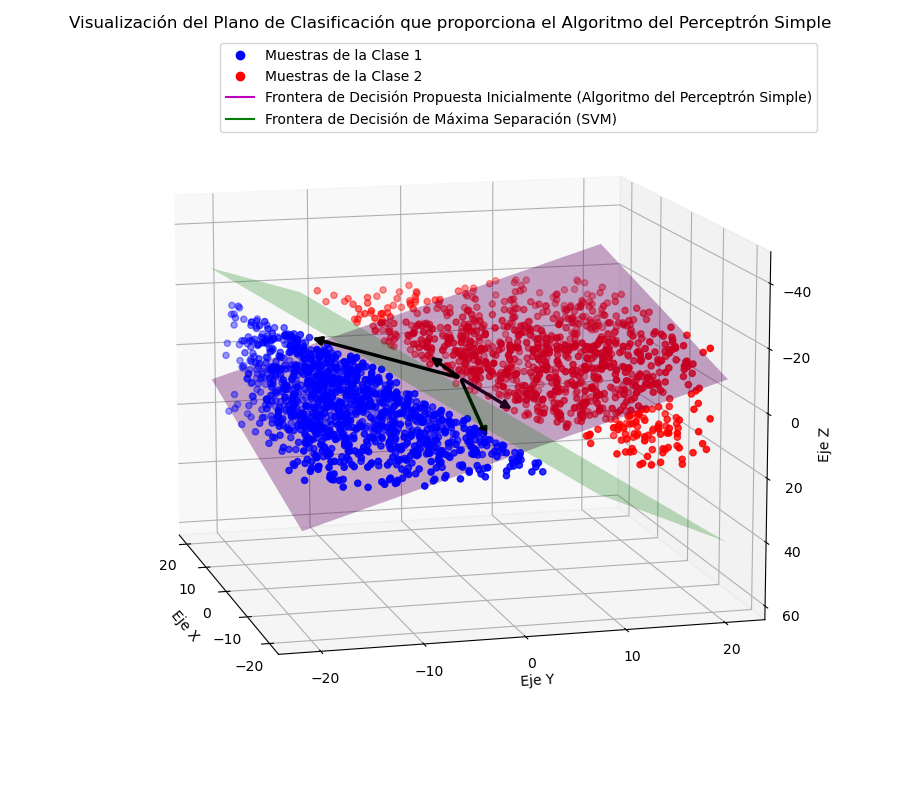

/tmp/ipykernel_50423/868274307.py:107: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')


In [10]:
%matplotlib notebook

listaPuntosClase1PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase1], numeroDimensiones)
listaPuntosClase2PorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(muestraPuntosPorClases[nombreClase2], numeroDimensiones)
valoresCoordenadasXPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[0]
valoresCoordenadasXPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[0]
valoresCoordenadasYPuntosClase1 = None
valoresCoordenadasYPuntosClase2 = None
valoresCoordenadasZPuntosClase1 = None
valoresCoordenadasZPuntosClase2 = None
minimoEjeX = np.min(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) - 1
maximoEjeX = np.max(valoresCoordenadasXPuntosClase1 + valoresCoordenadasXPuntosClase2) + 1
minimoEjeY = None
maximoEjeY = None
minimoEjeZ = None
maximoEjeZ = None

numeroMuestrasHiperplanoClasificacion = 10
if numeroDimensiones == 1:
    valoresCoordenadasYPuntosClase1 = [0.0] * len(listaPuntosClase1PorCoordenadasRespectivas[0])
    valoresCoordenadasYPuntosClase2 = [0.0] * len(listaPuntosClase2PorCoordenadasRespectivas[0])
    
    plt.figure(num = 1, figsize = (9, 3))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.axvline(x = -listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoBase[numeroDimensiones - 1], color = 'm', linestyle = '-', label = "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)", linewidth = 2.5)
    plt.axvline(x = -listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones] / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1], color = 'g', linestyle = '-', label = "Frontera de Decisión de Máxima Separación (SVM)", linewidth = 2.5)
    for vector in listaVectoresSoporte:
        plt.arrow(0, 0, vector[numeroDimensiones - 1], 0.0, head_width = 0.4, head_length = 0.4, fc = 'k', ec = 'k')
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("")
    plt.gca().get_yaxis().set_visible(False)
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 2:
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
    
    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoBase[numeroDimensiones]) / listaCoeficientesHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoBase[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion
    
    listaValoresCoordenadaXHiperplanoSeparacionMaxima = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoSeparacionMaxima = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaYHiperplanoSeparacionMaxima = -(listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones]) / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1]
    elif listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoSeparacionMaxima = [-listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones] / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2]] * numeroMuestrasHiperplanoClasificacion

    plt.figure(num = 1, figsize = (9, 8))
    plt.plot(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, 'bo', label = "Muestras de la Clase 1")
    plt.plot(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, 'ro', label = "Muestras de la Clase 2")
    plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'm-', label = "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)")
    plt.plot(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima, 'g-', label = "Frontera de Decisión de Máxima Separación (SVM)")
    for vector in listaVectoresSoporte:
        plt.arrow(0, 0, vector[numeroDimensiones - 2], vector[numeroDimensiones - 1], head_width = 0.4, head_length = 0.4, fc = 'k', ec = 'k')
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title("Visualización de la Recta de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 3:
    valoresCoordenadasYPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[1]
    valoresCoordenadasYPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[1]
    valoresCoordenadasZPuntosClase1 = listaPuntosClase1PorCoordenadasRespectivas[2]
    valoresCoordenadasZPuntosClase2 = listaPuntosClase2PorCoordenadasRespectivas[2]
    minimoEjeY = np.min(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) - 1
    maximoEjeY = np.max(valoresCoordenadasYPuntosClase1 + valoresCoordenadasYPuntosClase2) + 1
    minimoEjeZ = np.min(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) - 1
    maximoEjeZ = np.max(valoresCoordenadasZPuntosClase1 + valoresCoordenadasZPuntosClase2) + 1

    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaZHiperplanoBase = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesHiperplanoBase[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
        listaValoresCoordenadaZHiperplanoBase = -(listaCoeficientesHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesHiperplanoBase[numeroDimensiones]) / listaCoeficientesHiperplanoBase[numeroDimensiones - 1]
    elif listaCoeficientesHiperplanoBase[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaYHiperplanoBase = -(listaCoeficientesHiperplanoBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesHiperplanoBase[numeroDimensiones]) / listaCoeficientesHiperplanoBase[numeroDimensiones - 2]
    elif listaCoeficientesHiperplanoBase[numeroDimensiones - 3] != 0.0:
        listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase = np.meshgrid(listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase)
        listaValoresCoordenadaXHiperplanoBase = [-listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoBase[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion
    
    listaValoresCoordenadaXHiperplanoSeparacionMaxima = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaYHiperplanoSeparacionMaxima = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoClasificacion)
    listaValoresCoordenadaZHiperplanoSeparacionMaxima = np.linspace(minimoEjeZ, maximoEjeZ, num = numeroMuestrasHiperplanoClasificacion)
    if listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1] != 0.0:
        listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima = np.meshgrid(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima)
        listaValoresCoordenadaZHiperplanoSeparacionMaxima = -(listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones]) / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 1]
    elif listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2] != 0.0:
        listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima = np.meshgrid(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima)
        listaValoresCoordenadaYHiperplanoSeparacionMaxima = -(listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoSeparacionMaxima + listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones]) / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 2]
    elif listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3] != 0.0:
        listaValoresCoordenadaYHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima = np.meshgrid(listaValoresCoordenadaYHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima)
        listaValoresCoordenadaXHiperplanoSeparacionMaxima = [-listaCoeficientesHiperplanoBase[numeroDimensiones] / listaCoeficientesHiperplanoSeparacionMaxima[numeroDimensiones - 3]] * numeroMuestrasHiperplanoClasificacion
    
    currentFigure = plt.figure(num = 1, figsize = (9, 8))
    ax = currentFigure.gca(projection = '3d')
    ax.view_init(elev = -168, azim = 15) #Se ajusta la perspectiva manualmente de forma que se pueda visualizar los planos de separacion, los vectores de soporte y evidencia que separen los datos segun la clase a la que pertenecen (Si se cambia de plano para generar los puntos de muestra, se recomienda ajustar adecuadamente la perspectiva)
    ax.scatter(valoresCoordenadasXPuntosClase1, valoresCoordenadasYPuntosClase1, valoresCoordenadasZPuntosClase1, c = 'b', marker = 'o')
    etiquetaLeyendaPuntosClase1 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'b', marker = 'o')
    ax.scatter(valoresCoordenadasXPuntosClase2, valoresCoordenadasYPuntosClase2, valoresCoordenadasZPuntosClase2, c = 'r', marker = 'o')
    etiquetaLeyendaPuntosClase2 = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'm', alpha = 0.35)
    etiquetaLeyendaPlanoBase = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'm')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoSeparacionMaxima, listaValoresCoordenadaYHiperplanoSeparacionMaxima, listaValoresCoordenadaZHiperplanoSeparacionMaxima, color = 'g', alpha = 0.25)
    etiquetaLeyendaPlanoSeparacionMaxima = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
    for vector in listaVectoresSoporte:
        flechaVector = Arrow3D([0.0, vector[numeroDimensiones - 3]], [0.0, vector[numeroDimensiones - 2]], [0.0, vector[numeroDimensiones - 1]], mutation_scale = 12, lw = 2.5, arrowstyle = "-|>", color = "k")
        ax.add_artist(flechaVector)
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_zlabel("Eje Z")
    ax.set_title("Visualización del Plano de Clasificación que proporciona el Algoritmo del Perceptrón Simple")
    ax.legend([etiquetaLeyendaPuntosClase1, etiquetaLeyendaPuntosClase2, etiquetaLeyendaPlanoBase, etiquetaLeyendaPlanoSeparacionMaxima], ["Muestras de la Clase 1", "Muestras de la Clase 2", "Frontera de Decisión Propuesta Inicialmente (Algoritmo del Perceptrón Simple)", "Frontera de Decisión de Máxima Separación (SVM)"], numpoints = 1)
    plt.tight_layout()
    plt.show()

No hay archivos con extensión ['.jpg'] para eliminar, en la carpeta ./Figuras/


<IPython.core.display.Javascript object>


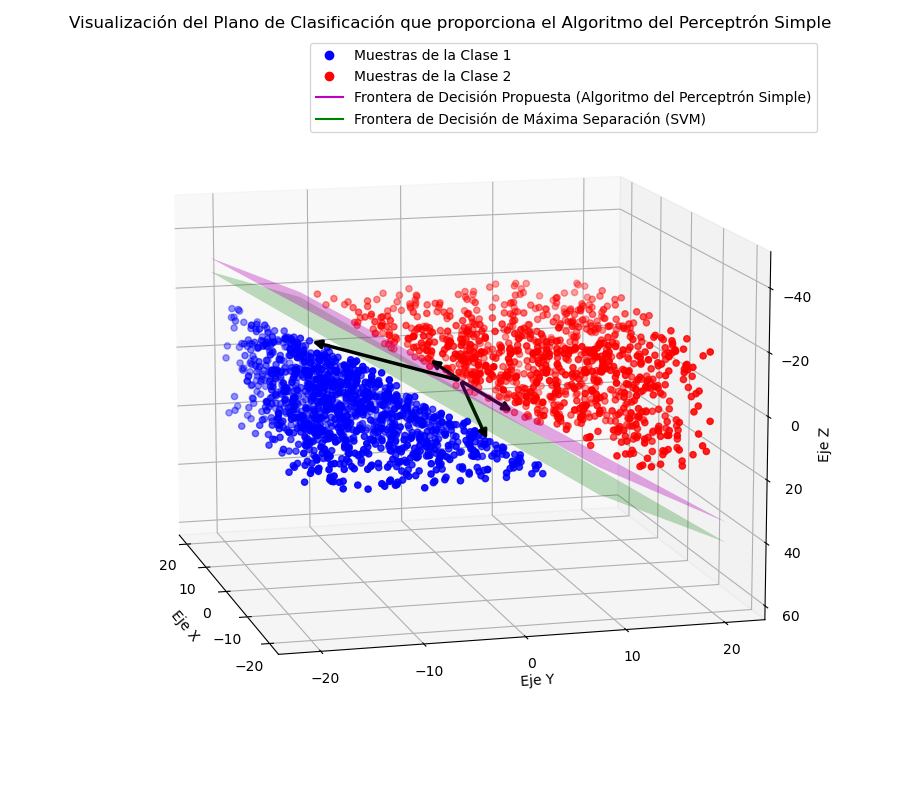

/tmp/ipykernel_50423/609463891.py:174: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')


In [11]:
listaCoeficientesHiperplanoSeparacion, listaCantidadesVerdaderosPositivos, listaCantidadesVerdaderosNegativos, listaCantidadesFalsosPositivos, listaCantidadesFalsosNegativos, numeroPasos = algoritmoPerceptronSimple(listaCoeficientesHiperplanoBase, listaCoeficientesHiperplanoSeparacionMaxima, listaVectoresSoporte, listaPuntosMuestra, muestraPuntosPorClases, nombreClase1, nombreClase2, tasaAprendizaje, numeroDimensiones)

In [12]:
endInstantTime = time.time()
fullRunningTime = endInstantTime - startInstantTime
runningTimeInMinutes = int(fullRunningTime / 60)
runningTimeInSeconds = int(fullRunningTime % 60)
print("Tiempo de Ejecución (Hasta esta parte): {} minutos y {} segundos".format(runningTimeInMinutes, runningTimeInSeconds))

Tiempo de Ejecución (Hasta esta parte): 3 minutos y 25 segundos


In [13]:
animationFilename = ""
if (numeroDimensiones == 1 or numeroDimensiones == 2 or numeroDimensiones == 3) and numeroPasos > 0:
    animationFilename = createAnimationFromImageFilesAtSomeDirectory(searchFolderPath, imageFileExtensionsList, nombreArchivoAnimacion, animationFileExtension, framesPorSegundoAnimacion)
    mensajeConfirmacion = deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
    print(printColouredText(mensajeConfirmacion, colorTextoRojo))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (783, 790) to (784, 800) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Se han ajustado 812 imágen(es) a un tamaño común que es de 783x790 como máximo de ancho por máximo de alto


[swscaler @ 0x5ddd740] Warning: data is not aligned! This can lead to a speed loss


Se ha creado el archivo ./Figuras/Animación del Perceptrón Simple.mp4
Hay 812 archivos con extensión ['.jpg'] para eliminar, en la carpeta ./Figuras/


In [14]:
Video(animationFilename, width = 850)

In [15]:
textoEcuacionHiperplanoSeparacion = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoSeparacion)
if numeroDimensiones == 1 or numeroDimensiones == 2:
    print("La recta obtenida al ejecutar el algoritmo del perceptrón simple, está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El plano obtenido al ejecutar el algoritmo del perceptrón simple, está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El hiperplano obtenido al ejecutar el algoritmo del perceptrón simple, está dado por la ecuación:")

display(Math(textoEcuacionHiperplanoSeparacion))

El plano obtenido al ejecutar el algoritmo del perceptrón simple, está dado por la ecuación:


<IPython.core.display.Math object>

In [16]:
if numeroDimensiones == 1 or numeroDimensiones == 2:
    print("Al ejecutar el algoritmo del perceptrón simple, se requirió de", printColouredText(str(numeroPasos) + " paso(s)", colorTextoVerde), "para encontrar una recta que separe perfectamente los puntos de muestra de las 2 clases")
elif numeroDimensiones == 3:
    print("Al ejecutar el algoritmo del perceptrón simple, se requirió de", printColouredText(str(numeroPasos) + " paso(s)", colorTextoVerde), "para encontrar un plano que separe perfectamente los puntos de muestra de las 2 clases")
elif numeroDimensiones >= 4:
    print("Al ejecutar el algoritmo del perceptrón simple, se requirió de", printColouredText(str(numeroPasos) + " paso(s)", colorTextoVerde), "para encontrar un hiperplano que separe perfectamente los puntos de muestra de las 2 clases")

Al ejecutar el algoritmo del perceptrón simple, se requirió de 812 paso(s) para encontrar un plano que separe perfectamente los puntos de muestra de las 2 clases


<IPython.core.display.Javascript object>


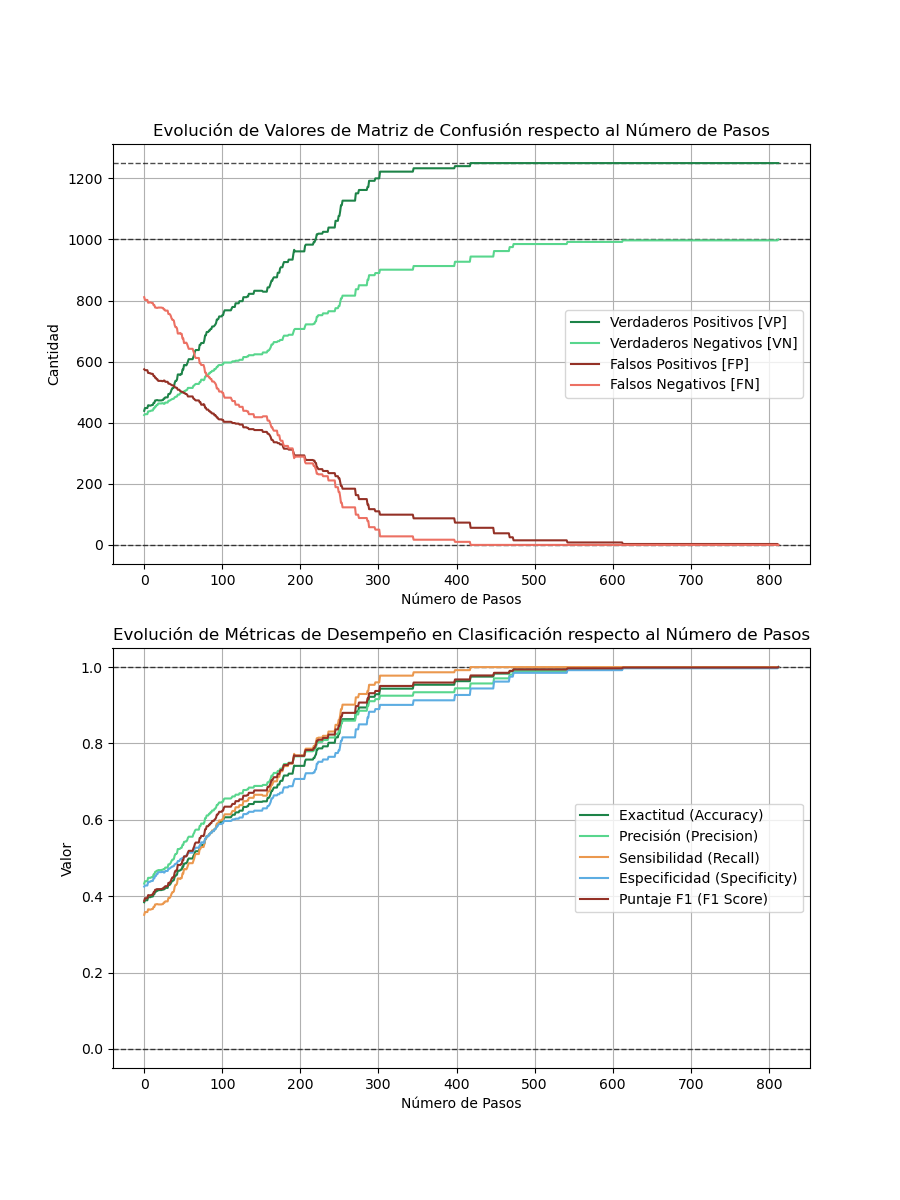

In [17]:
listaCantidadesVerdaderosPositivos = np.array(listaCantidadesVerdaderosPositivos)
listaCantidadesVerdaderosNegativos = np.array(listaCantidadesVerdaderosNegativos)
listaCantidadesFalsosPositivos = np.array(listaCantidadesFalsosPositivos)
listaCantidadesFalsosNegativos = np.array(listaCantidadesFalsosNegativos)
listaValoresExactitud = np.divide(listaCantidadesVerdaderosPositivos + listaCantidadesVerdaderosNegativos, listaCantidadesVerdaderosPositivos + listaCantidadesFalsosPositivos + listaCantidadesVerdaderosNegativos + listaCantidadesFalsosNegativos)
listaValoresPrecision = np.divide(listaCantidadesVerdaderosPositivos, listaCantidadesVerdaderosPositivos + listaCantidadesFalsosPositivos)
listaValoresSensibilidad = np.divide(listaCantidadesVerdaderosPositivos, listaCantidadesVerdaderosPositivos + listaCantidadesFalsosNegativos)
listaValoresEspecificidad = np.divide(listaCantidadesVerdaderosNegativos, listaCantidadesVerdaderosNegativos + listaCantidadesFalsosPositivos)
listaValoresPuntajeF1 = np.divide(2 * listaValoresPrecision * listaValoresSensibilidad, listaValoresPrecision + listaValoresSensibilidad)

if numeroPasos > 0:
    plt.figure(num = 3, figsize = (9, 12))
    plt.subplot(211)
    plt.axhline(y = len(muestraPuntosPorClases[nombreClase1]), color = 'k', linestyle = '--', linewidth = 1, alpha = 0.7)
    plt.axhline(y = len(muestraPuntosPorClases[nombreClase2]), color = 'k', linestyle = '--', linewidth = 1, alpha = 0.7)
    plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth = 1, alpha = 0.7)
    plt.plot(listaCantidadesVerdaderosPositivos, color = '#1D8348', linestyle = '-', label = 'Verdaderos Positivos [VP]', linewidth = 1.5)
    plt.plot(listaCantidadesVerdaderosNegativos, color = '#58D68D', linestyle = '-', label = 'Verdaderos Negativos [VN]', linewidth = 1.5)
    plt.plot(listaCantidadesFalsosPositivos, '#943126', linestyle = '-', label = 'Falsos Positivos [FP]', linewidth = 1.5)
    plt.plot(listaCantidadesFalsosNegativos, '#EC7063', linestyle = '-', label = 'Falsos Negativos [FN]', linewidth = 1.5)
    plt.title('Evolución de Valores de Matriz de Confusión respecto al Número de Pasos')
    plt.xlabel('Número de Pasos')
    plt.ylabel('Cantidad')
    plt.legend(labelcolor = 'k', loc = 'center right')
    plt.grid(True)
    plt.subplot(212)
    plt.axhline(y = 1.0, color = 'k', linestyle = '--', linewidth = 1, alpha = 0.7)
    plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth = 1, alpha = 0.7)
    plt.plot(listaValoresExactitud, color = '#1D8348', linestyle = '-', label = 'Exactitud (Accuracy)', linewidth = 1.5)
    plt.plot(listaValoresPrecision, color = '#58D68D', linestyle = '-', label = 'Precisión (Precision)', linewidth = 1.5)
    plt.plot(listaValoresSensibilidad, color = '#EB984E', linestyle = '-', label = 'Sensibilidad (Recall)', linewidth = 1.5)
    plt.plot(listaValoresEspecificidad, color = '#5DADE2', linestyle = '-', label = 'Especificidad (Specificity)', linewidth = 1.5)
    plt.plot(listaValoresPuntajeF1, color = '#943126', linestyle = '-', label = 'Puntaje F1 (F1 Score)', linewidth = 1.5)
    plt.title('Evolución de Métricas de Desempeño en Clasificación respecto al Número de Pasos')
    plt.xlabel('Número de Pasos')
    plt.ylabel('Valor')
    plt.legend(labelcolor = 'k', loc = 'center right')
    plt.grid(True)
    plt.show()

In [18]:
endInstantTime = time.time()
fullRunningTime = endInstantTime - startInstantTime
runningTimeInMinutes = int(fullRunningTime / 60)
runningTimeInSeconds = int(fullRunningTime % 60)
print("Tiempo de Ejecución: {} minutos y {} segundos".format(runningTimeInMinutes, runningTimeInSeconds))

Tiempo de Ejecución: 3 minutos y 37 segundos
